<a href="https://colab.research.google.com/github/shaon6009/Deep-Learning-Projects/blob/main/LipNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install and Import Dependencies

In [ ]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         0.34.2
aiohappyeyeballs                   2.4.3
aiohttp                            3.10.10
aiosignal                          1.3.1
alabaster                          0.7.16
albucore                           0.0.19
albumentations                     1.4.20
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.4
astropy-iers-data                  0.2024.10.28.0.34.7
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread        

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=4fee7ccf-85af-4e69-b314-22293ef76c15
To: /content/data.zip
100%|██████████| 423M/423M [00:10<00:00, 38.5MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [ ]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]

    # Construct paths
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    # Debugging prints to verify paths
    print(f"Video path: {video_path}")
    print(f"Alignment path: {alignment_path}")

    # Check if files exist before proceeding
    if not os.path.exists(video_path):
        print(f"Error: Video file {video_path} does not exist.")
        return None, None
    if not os.path.exists(alignment_path):
        print(f"Error: Alignment file {alignment_path} does not exist.")
        return None, None

    # Assuming these functions exist
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

Video path: data/s1/bbal6n.mpg
Alignment path: data/alignments/s1/bbal6n.align


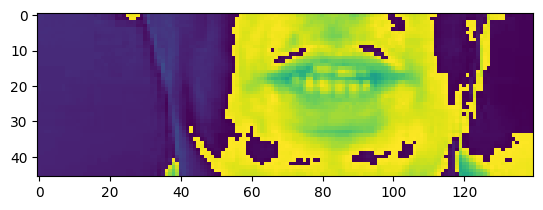

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    # Use tf.py_function to wrap load_data
    frames, alignments = tf.py_function(load_data, [path], [tf.float32, tf.int32])
    frames.set_shape([None, None, None, None])  # Adjust as per your frames' actual shape
    alignments.set_shape([None])  # Adjust as per your alignments' actual shape
    return frames, alignments

# 2. Create Data Pipeline

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
from typing import List, Tuple

def load_data(path: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    # Decode and extract file name using os.path for compatibility across OS
    path_str = path.numpy().decode('utf-8')
    file_name = os.path.splitext(os.path.basename(path_str))[0]

    # Construct paths
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')



    # Check if files exist before proceeding
    if not os.path.exists(video_path):
        print(f"Error: Video file {video_path} does not exist.")
        return tf.constant([], dtype=tf.float32), tf.constant([], dtype=tf.int32)
    if not os.path.exists(alignment_path):
        print(f"Error: Alignment file {alignment_path} does not exist.")
        return tf.constant([], dtype=tf.float32), tf.constant([], dtype=tf.int32)

    # Load frames and alignments if files exist
    frames = load_video(video_path)  # Replace with the actual function to load video frames
    alignments = load_alignments(alignment_path)  # Replace with the actual function to load alignments

    # Ensure frames are tf.float32 and alignments are tf.int32
    frames = tf.convert_to_tensor(frames, dtype=tf.float32)
    alignments = tf.convert_to_tensor(alignments, dtype=tf.int64)  # Convert to int64 first
    alignments = tf.cast(alignments, dtype=tf.int32)  # Then explicitly cast to int32

    return frames, alignments

In [ ]:
# Dataset setup
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))  # Adjust based on actual padding needs
data = data.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Split into train and test datasets
train = data.take(450)
test = data.skip(450)

In [ ]:
len(test)

50

In [ ]:
try:
    frames, alignments = next(iter(data))
    print(frames.shape)
    print(alignments.shape)
except Exception as e:
    print(f"Error during dataset iteration: {e}")

(2, 75, 46, 140, 1)
(2, 40)


In [ ]:
len(frames)

2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

array([[[[[1.5228868 ],
          [1.4086703 ],
          [0.9518042 ],
          ...,
          [0.34264952],
          [0.30457735],
          [0.30457735]],

         [[1.4467424 ],
          [1.4086703 ],
          [1.0660207 ],
          ...,
          [0.34264952],
          [0.30457735],
          [0.30457735]],

         [[1.332526  ],
          [1.4086703 ],
          [1.332526  ],
          ...,
          [0.3807217 ],
          [0.34264952],
          [0.34264952]],

         ...,

         [[1.1802373 ],
          [1.104093  ],
          [1.104093  ],
          ...,
          [0.        ],
          [0.        ],
          [0.03807217]],

         [[1.104093  ],
          [1.104093  ],
          [1.104093  ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[1.104093  ],
          [1.104093  ],
          [1.104093  ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]]],


        [[[1.5609

In [ ]:
# Assuming val[0][0] is a batch of frames with shape (num_frames, height, width, channels)
frames = val[0][0]

# Ensure frames are in uint8 format and have the right shape
# Convert to uint8 if not already
frames = (frames * 255).astype(np.uint8)

# Remove single color channel if frames are grayscale
if frames.shape[-1] == 1:
    frames = frames[..., 0]  # Remove the last dimension if it's (height, width, 1)

# Save frames as a GIF
imageio.mimsave('./animation.gif', frames, fps=10)


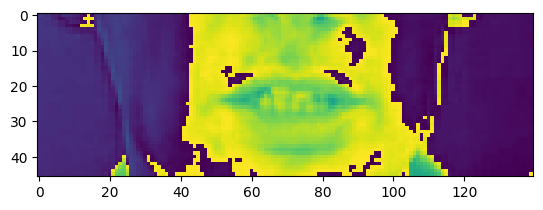

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green with h nine soon'>

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
num_samples = 100  # Number of samples
time_steps = 75    # Number of time steps
height = 32        # Reduced height
width = 100        # Reduced width
channels = 1       # Number of channels (e.g., grayscale images)
num_classes = 10   # Number of classes for classification

X_train = np.random.rand(num_samples, time_steps, height, width, channels).astype(np.float32)
y_train = np.random.randint(0, num_classes, size=(num_samples, time_steps)).astype(np.int64)

X_test = np.random.rand(num_samples, time_steps, height, width, channels).astype(np.float32)
y_test = np.random.randint(0, num_classes, size=(num_samples, time_steps)).astype(np.int64)

model = Sequential()
model.add(Conv3D(128, kernel_size=3, input_shape=(time_steps, height, width, channels), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(Conv3D(75, kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_114 (Conv3D)                  │ (None, 75, 32, 100, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_108 (Activation)          │ (None, 75, 32, 100, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_114 (MaxPooling3D)     │ (None, 75, 16, 50, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_115 (Conv3D)                  │ (None, 75, 16, 50, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_109 (Activation)          │ (None, 75, 16, 50, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_115 (MaxPooling3D)     │ (None, 75, 8, 25, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_116 (Conv3D)                  │ (None, 75, 8, 25, 75)       │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_110 (Activation)          │ (None, 75, 8, 25, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_116 (MaxPooling3D)     │ (None, 75, 4, 12, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_44                  │ (None, 75, 3600)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_76 (Bidirectional)     │ (None, 75, 256)             │       3,818,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_155 (Dropout)                │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_77 (Bidirectional)     │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_156 (Dropout)                │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,630,324 (21.48 MB)

 Trainable params: 5,630,324 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('models', 'checkpoint.weights.h5'),
    monitor='loss',
    save_weights_only=True
)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=4, callbacks=[checkpoint_callback])

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 717ms/step - accuracy: 0.0857 - loss: 3.1859 - val_accuracy: 0.1055 - val_loss: 2.4185
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 681ms/step - accuracy: 0.0938 - loss: 2.5955 - val_accuracy: 0.1015 - val_loss: 2.3666
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 720ms/step - accuracy: 0.1080 - loss: 2.5424 - val_accuracy: 0.1013 - val_loss: 2.3531
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 727ms/step - accuracy: 0.0984 - loss: 2.5044 - val_accuracy: 0.1008 - val_loss: 2.3471
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 693ms/step - accuracy: 0.0977 - loss: 2.4809 - val_accuracy: 0.1019 - val_loss: 2.3415
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 727ms/step - accuracy: 0.0939 - loss: 2.4734 - val_accuracy: 0.1068 - val_loss: 2.3385
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 730ms/step - accuracy: 0.1037 - loss: 2.4632 - val_accuracy: 0.1000 - val_loss: 2.3369
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 739ms/step - accuracy: 0.1017 - loss: 2.4598 - val_accu

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print("Training Accuracy: ", train_accuracy[-1])
print("Validation Accuracy: ", val_accuracy[-1])

Training Accuracy:  0.4475999176502228
Validation Accuracy:  0.09386667609214783


In [ ]:

# num_samples = 100  # Number of samples
# time_steps = 75    # Number of time steps
# height = 32        # Reduced height
# width = 100        # Reduced width
# channels = 1       # Number of channels (e.g., grayscale images)
# num_classes = 10   # Number of classes for classification

# # Generate random training data
# X_train = np.random.rand(num_samples, time_steps, height, width, channels).astype(np.float32)
# y_train = np.random.randint(0, num_classes, size=(num_samples, time_steps)).astype(np.int64)

# X_test = np.random.rand(num_samples, time_steps, height, width, channels).astype(np.float32)
# y_test = np.random.randint(0, num_classes, size=(num_samples, time_steps)).astype(np.int64)

# model = Sequential()
# model.add(Conv3D(32, kernel_size=3, input_shape=(time_steps, height, width, channels), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(64, kernel_size=3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(75, kernel_size=3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D(pool_size=(1, 2, 2)))

# model.add(TimeDistributed(Flatten()))

# model.add(Bidirectional(LSTM(32, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(0.5))

# model.add(Bidirectional(LSTM(32, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(0.5))

# # Define the output layer
# model.add(Dense(num_classes, kernel_initializer='he_normal', activation='softmax'))

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')

# # Define the model checkpoint callback
# checkpoint_callback = ModelCheckpoint(
#     filepath=os.path.join('models', 'checkpoint.weights.h5'),
#     monitor='loss',
#     save_weights_only=True
# )

# # Create TensorFlow datasets and repeat them
# batch_size = 4
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).repeat()
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)  # No repeat on test

# # Fit the model with the dataset
# model.fit(train_dataset, validation_data=test_dataset, epochs=2, callbacks=[checkpoint_callback])

In [ ]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'dgggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg'>

In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'dgggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg'>

# 5. Make a Prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=e4dabcf9-d87d-4b64-bd19-0cf2ca460690
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 92.2MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
model.load_weights('models/checkpoint.weights.h5')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75, 75], greedy=True)[0][0].numpy()

In [ ]:


print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'dg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'dhgdg'>]

# Test on a Video

In [ ]:
video_path = './data/s1/bras9a.mpg'  # Adjust the path according to your setup
sample = load_data(tf.convert_to_tensor(video_path))

In [ ]:
print('~'*100, 'REAL TEXT')
real_text_video = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]
print(real_text_video)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]


In [ ]:
yhat_video = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [ ]:
decoded_video = tf.keras.backend.ctc_decode(yhat_video, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
predictions_video = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded_video]
print(predictions_video)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
[<tf.Tensor: shape=(), dtype=string, numpy=b'dgdg'>]
